In [82]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from SullivanCP import ChangePoint
import ruptures as rpt
from sklearn.linear_model import LogisticRegression
from math import sqrt

# Examine first two images of both classes

In [2]:
array = np.array([1,2,3])
array2 = np.array([10,20,30])
pd.DataFrame([array,array2])

0   1   2
0   1   2   3
1  10  20  30

In [3]:
image = Image.open(r'F:\Docs\QE\Project\Class1\Class1\1.png')
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

PNG
(512, 512)
L


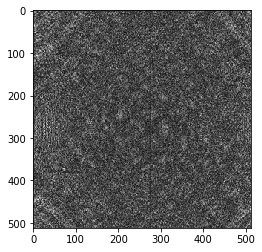

In [4]:
plt.imshow(image, cmap='gray')
plt.show()

In [5]:
arrayImage = np.asarray(image)

In [6]:
arrayImage

array([[ 77, 107, 175, ..., 124,  75,  95],
       [178,  76, 182, ..., 179,  75, 131],
       [144, 109, 134, ..., 161,  68, 174],
       ...,
       [ 82, 103, 106, ...,  83, 112, 112],
       [187, 132, 134, ...,  73,  78,  96],
       [119,  91, 116, ...,  25, 131, 106]], dtype=uint8)

In [7]:
arrayImage.shape

(512, 512)

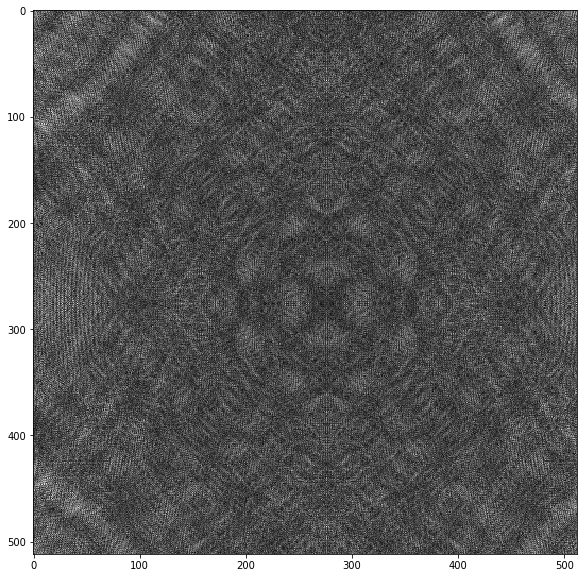

In [8]:
plt.figure(figsize = (10,10))
plt.imshow(arrayImage, cmap = 'gray')

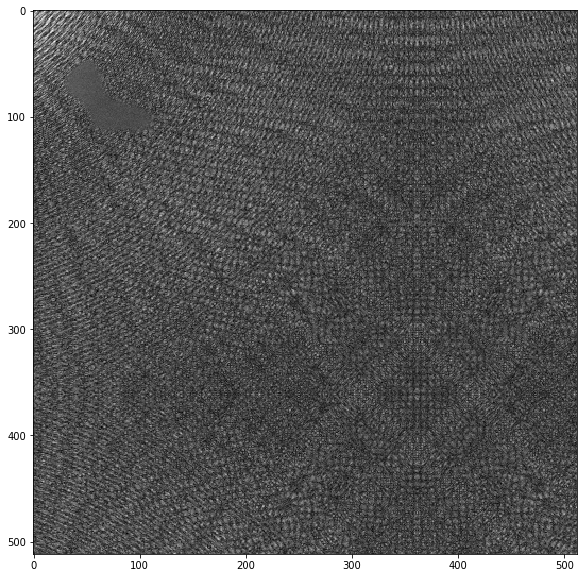

In [9]:
defect = Image.open(r'F:\Docs\QE\Project\Class1_def\Class1_def\1.png')
arrayDefect = np.asarray(defect)
plt.figure(figsize = (10,10))
plt.imshow(arrayDefect, cmap = 'gray')

# Load all images

In [10]:
data = []
images = []
for i in np.arange(1,1001):
    data.append(np.asarray(Image.open("F:\Docs\QE\Project\Class1\Class1\\"+str(i)+'.png')).flatten())
    images.append(Image.open("F:\Docs\QE\Project\Class1\Class1\\"+str(i)+'.png'))

In [11]:
df = pd.DataFrame([data, images, np.zeros(1000)], index = ['data', 'image', 'class']).T

In [12]:
dfdata = pd.DataFrame(data)

In [13]:
data = []
images = []
for i in np.arange(1,151):
    data.append(np.asarray(Image.open("F:\Docs\QE\Project\Class1_def\Class1_def\\"+str(i)+'.png')).flatten())
    images.append(Image.open("F:\Docs\QE\Project\Class1_def\Class1_def\\"+str(i)+'.png'))

In [14]:
temp = pd.DataFrame([data, images, np.ones(150)], index = ['data', 'image', 'class']).T
dfdata = pd.concat([dfdata,pd.DataFrame(data)])
df = pd.concat([df, temp])
df = df.reset_index(drop=True)
del data, images, temp #clear up some memory

In [15]:
df.head(5)

data  \
0  [77, 107, 175, 96, 89, 142, 113, 131, 132, 131...   
1  [136, 73, 80, 124, 116, 120, 80, 89, 71, 75, 1...   
2  [82, 83, 91, 21, 121, 72, 68, 105, 86, 58, 38,...   
3  [129, 84, 78, 19, 77, 88, 41, 84, 72, 74, 58, ...   
4  [68, 48, 51, 60, 77, 63, 57, 89, 71, 29, 77, 9...   

                                               image class  
0  <PIL.PngImagePlugin.PngImageFile image mode=L ...     0  
1  <PIL.PngImagePlugin.PngImageFile image mode=L ...     0  
2  <PIL.PngImagePlugin.PngImageFile image mode=L ...     0  
3  <PIL.PngImagePlugin.PngImageFile image mode=L ...     0  
4  <PIL.PngImagePlugin.PngImageFile image mode=L ...     0

In [16]:
df.tail(5)

data  \
1145  [47, 80, 53, 79, 70, 58, 57, 95, 46, 66, 71, 9...   
1146  [30, 64, 91, 46, 27, 67, 104, 77, 58, 73, 27, ...   
1147  [153, 99, 66, 148, 131, 72, 75, 102, 72, 34, 4...   
1148  [44, 96, 63, 77, 89, 98, 121, 75, 85, 57, 33, ...   
1149  [75, 54, 68, 58, 96, 56, 64, 77, 45, 82, 34, 5...   

                                                  image class  
1145  <PIL.PngImagePlugin.PngImageFile image mode=L ...     1  
1146  <PIL.PngImagePlugin.PngImageFile image mode=L ...     1  
1147  <PIL.PngImagePlugin.PngImageFile image mode=L ...     1  
1148  <PIL.PngImagePlugin.PngImageFile image mode=L ...     1  
1149  <PIL.PngImagePlugin.PngImageFile image mode=L ...     1

In [17]:
df['class'] = df['class'].astype(int)

In [18]:
df['class'].describe()

count    1150.000000
mean        0.130435
std         0.336928
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: class, dtype: float64

# Build Classification Models

In [19]:
X = dfdata
y = df['class']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [21]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.85


In [22]:
confusion_matrix(y_test, knn.predict(X_test))

array([[321,   8],
       [ 49,   2]], dtype=int64)

This model performed very poorly, it predicted a defect 30 times and all of them were incorrrect. Let's try applying PCA.

In [23]:
y_train.sum()

99

In [24]:
pca = PCA(n_components = 100, random_state = 0)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [25]:
image_shape = arrayImage.shape

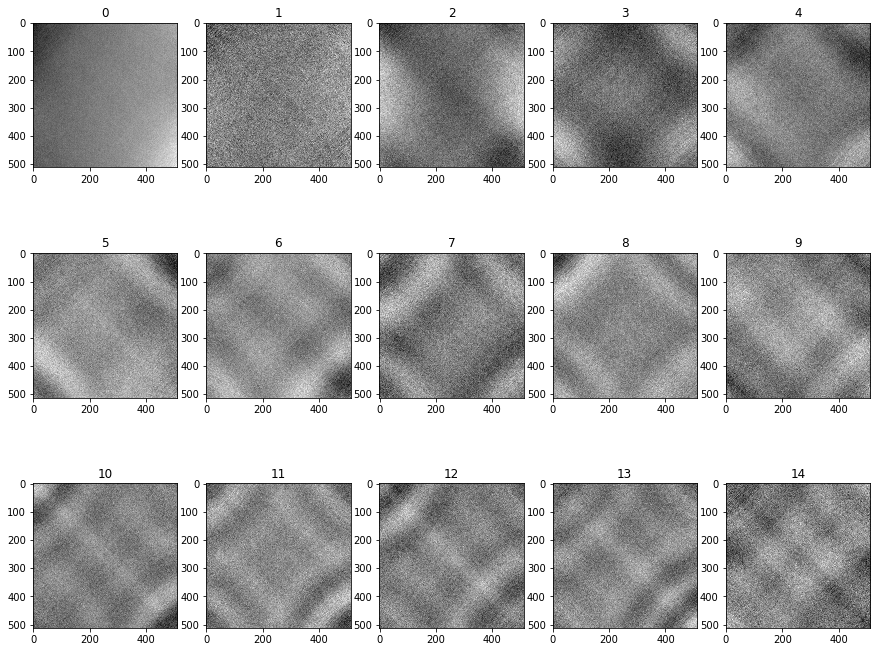

In [26]:
# pca visualization code adapted from:
# Müller, A. C., Guido, S. (2016). Introduction to Machine Learning with Python: A Guide for Data Scientists. United States: O'Reilly Media.
# https://www.google.com/books/edition/Introduction_to_Machine_Learning_with_Py/vbQlDQAAQBAJ?hl=en&gbpv=0

fig, axes = plt.subplots(3,5,figsize = (15,12))
for i, (component,ax) in enumerate(zip(pca.components_,axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap = 'gray')
    ax.set_title(i)

In [27]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_pca, y_train)
print(knn.score(X_test_pca, y_test))

0.8342105263157895


In [28]:
confusion_matrix(y_test, knn.predict(X_test_pca))

array([[316,  13],
       [ 50,   1]], dtype=int64)

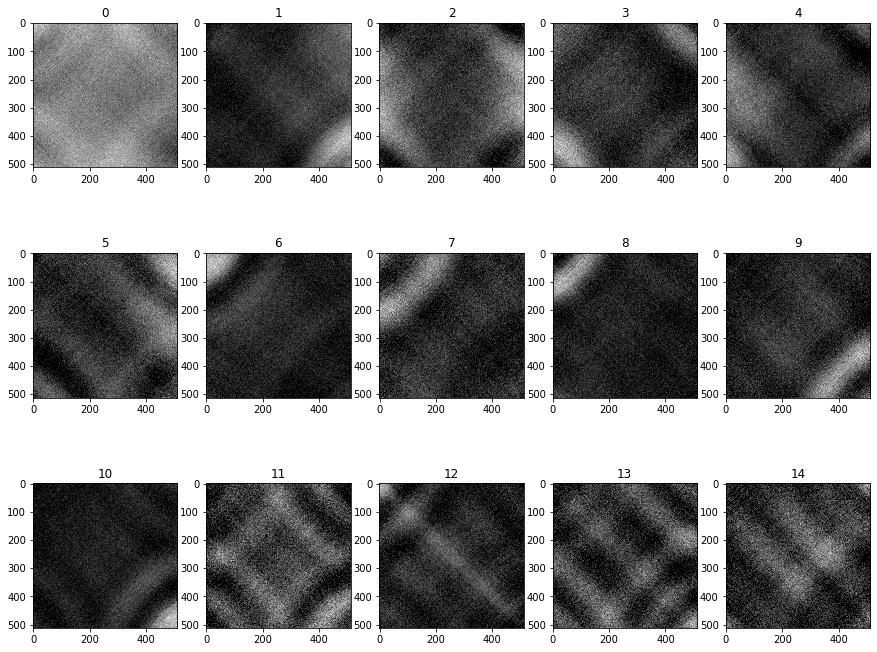

In [29]:
# nmf visualization code adapted from:
# Müller, A. C., Guido, S. (2016). Introduction to Machine Learning with Python: A Guide for Data Scientists. United States: O'Reilly Media.
# https://www.google.com/books/edition/Introduction_to_Machine_Learning_with_Py/vbQlDQAAQBAJ?hl=en&gbpv=0

nmf = NMF(n_components = 15, random_state = 0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fig, axes = plt.subplots(3,5,figsize = (15,12))
for i, (component,ax) in enumerate(zip(nmf.components_,axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap = 'gray')
    ax.set_title(i)

In [30]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_nmf, y_train)
print(knn.score(X_train_nmf, y_train))
print(knn.score(X_test_nmf, y_test))

0.8779220779220779
0.868421052631579


In [31]:
confusion_matrix(y_test, knn.predict(X_test_nmf))

array([[328,   1],
       [ 49,   2]], dtype=int64)

In [32]:
rfc = RandomForestClassifier(n_estimators = 10)
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))

0.9766233766233766
0.8605263157894737


In [33]:
confusion_matrix(y_test, rfc.predict(X_test))

array([[327,   2],
       [ 51,   0]], dtype=int64)

In [34]:
rfc = RandomForestClassifier(n_estimators = 10)
rfc.fit(X_train_nmf, y_train)
print(rfc.score(X_train_nmf, y_train))
print(rfc.score(X_test_nmf, y_test))

0.9844155844155844
0.8657894736842106


In [35]:
confusion_matrix(y_test, rfc.predict(X_test_nmf))

array([[329,   0],
       [ 51,   0]], dtype=int64)

In [36]:
rfc = RandomForestClassifier(n_estimators = 10)
rfc.fit(X_train_pca, y_train)
print(rfc.score(X_train_pca, y_train))
print(rfc.score(X_test_pca, y_test))

0.9766233766233766
0.8657894736842106


In [37]:
confusion_matrix(y_test, rfc.predict(X_test_pca))

array([[329,   0],
       [ 51,   0]], dtype=int64)

# Use Contrasts

88.91534693783025


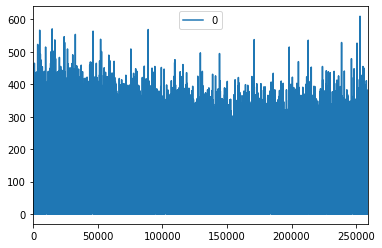

In [38]:
ndata = np.asarray(Image.open("F:\Docs\QE\Project\Class1_def\Class1_def\\"+str(2)+'.png'))
contrast = 0
contrasts = []
for i in np.arange(1,510):
        for j in np.arange(1,510):
            temp = abs(-4*abs(ndata[i][j])+abs(ndata[i][j-1])+abs(ndata[i][j+1])+abs(ndata[i-1][j])+abs(ndata[i+1][j]))
            contrast += temp
            contrasts.append(temp)
contrast = contrast/(509**2)
print(contrast)
defcontrasts = pd.DataFrame(contrasts)
defcontrasts.plot()

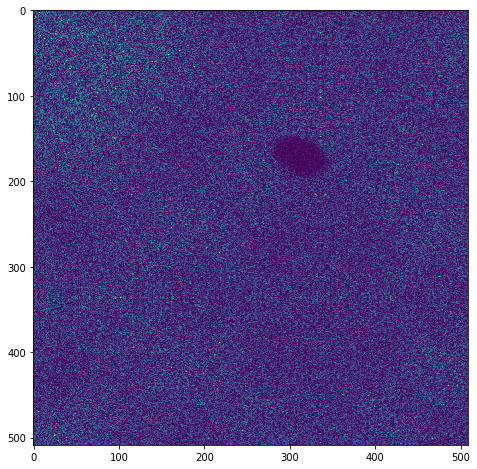

In [39]:
plt.figure(figsize =(8,8))
plt.imshow(np.array(defcontrasts).reshape(509,509))

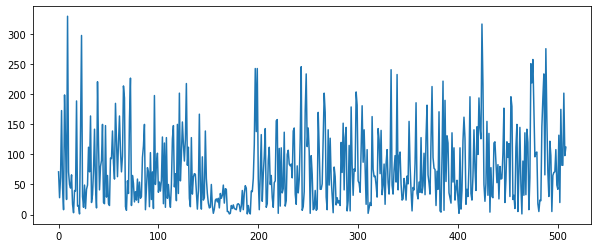

In [40]:
plt.figure(figsize = (10,4))
plt.plot(np.array(defcontrasts).reshape(509,509)[:,320])

In [41]:
ranges = abs(np.array(defcontrasts).reshape(509,509)[:,320][:-1]-np.array(defcontrasts).reshape(509,509)[:,320][1:])

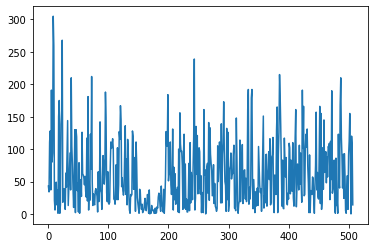

In [42]:
plt.plot(ranges)

In [43]:
dstar = ChangePoint(np.array(defcontrasts).reshape(509,509)[:,320])

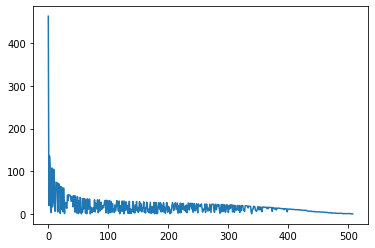

In [44]:
plt.plot(dstar)

In [45]:
dmaxes = []
for i in np.arange(0,round(509/10)):
    dstar = ChangePoint(np.array(defcontrasts).reshape(509,509)[:,i*10])
    dmaxes.append(sum(dstar[:2]))

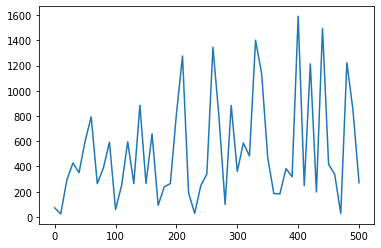

In [46]:
plt.plot(np.arange(0,round(509/10))*10,dmaxes)

In [47]:
# from https://github.com/deepcharles/ruptures
# C. Truong, L. Oudre, N. Vayatis. Selective review of offline change point detection methods. Signal Processing, 167:107299, 2020.

algo = rpt.Pelt(model="rbf").fit(signal = ranges)
result = algo.predict(pen=2)
result

[150, 195, 508]

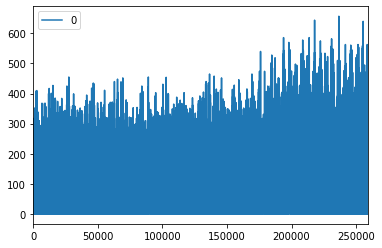

In [48]:
ndata = np.asarray(Image.open("F:\Docs\QE\Project\Class1\Class1\\"+str(2)+'.png'))
contrasts = []
for i in np.arange(1,510):
        for j in np.arange(1,510):
            temp = abs(-4*abs(ndata[i][j])+abs(ndata[i][j-1])+abs(ndata[i][j+1])+abs(ndata[i-1][j])+abs(ndata[i+1][j]))
            contrasts.append(temp)
contrasts = pd.DataFrame(contrasts)
contrasts.plot()

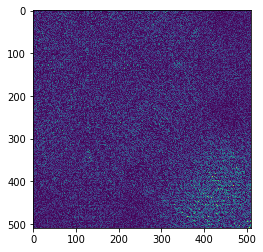

In [49]:
plt.imshow(np.array(contrasts).reshape(509,509))

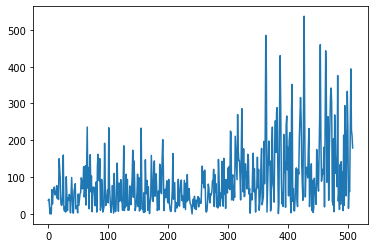

In [81]:
plt.plot(np.array(contrasts).reshape(509,509)[:,450])

In [51]:
dstar = ChangePoint(np.array(contrasts).reshape(509,509)[:,100])

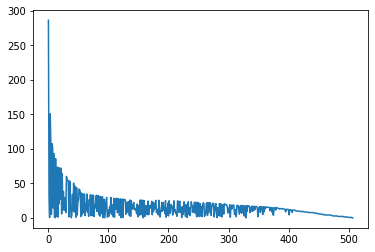

In [52]:
plt.plot(dstar)

In [53]:
max(dstar)

286.0726554797946

In [54]:
ranges = abs(np.array(contrasts).reshape(509,509)[:,320][:-1]-np.array(contrasts).reshape(509,509)[:,320][1:])

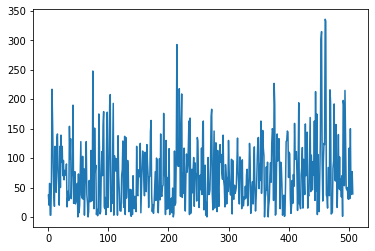

In [55]:
plt.plot(ranges)

In [56]:
algo = rpt.Pelt(model="rbf").fit(signal = ranges)
result = algo.predict(pen=2)
result

[508]

In [57]:
cps = []
chunks = 10
for i in np.arange(0,round(509/chunks)):
    ranges = abs(np.array(defcontrasts).reshape(509,509)[:,i*chunks][:-1]-np.array(defcontrasts).reshape(509,509)[:,i*chunks][1:])
    algo = rpt.Pelt(model="rbf").fit(signal = ranges)
    result = algo.predict(pen=5)
    cps.append(len(result))
cps = np.array(cps)

In [58]:
sum(cps[cps>=3])

12

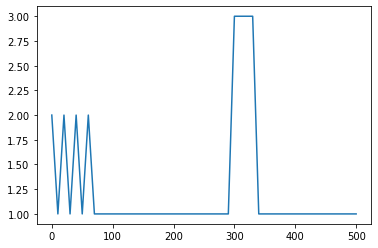

In [59]:
plt.plot(np.arange(0,round(509/chunks))*chunks, cps)

In [60]:
cps = []
for i in np.arange(0,round(509/chunks)):
    ranges = abs(np.array(contrasts).reshape(509,509)[:,i*chunks][:-1]-np.array(contrasts).reshape(509,509)[:,i*chunks][1:])
    algo = rpt.Pelt(model="rbf").fit(signal = ranges)
    result = algo.predict(pen=5)
    cps.append(len(result))
cps = np.array(cps)

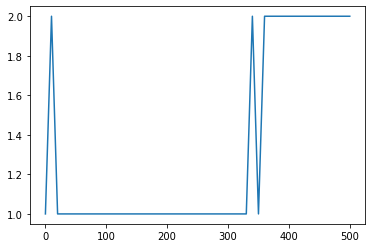

In [61]:
plt.plot( np.arange(0,round(509/10))*10, cps)

### Convert Data

In [62]:
cpdata = pd.read_csv('ChangePoints.csv', header = 0, index_col = 0)

In [63]:
cpdata.head()

0  1  2  3  4  5  6  7  8  9  ...  24  25  26  27  28  29  30  31  32  33
0  1  1  1  1  1  1  1  1  1  1  ...   2   1   1   1   1   1   1   1   1   1
1  1  1  1  1  1  1  1  1  1  1  ...   2   2   2   2   2   2   2   2   2   2
2  1  1  1  1  1  1  1  1  1  1  ...   1   1   1   1   1   1   1   1   1   1
3  2  1  1  1  1  1  1  1  1  1  ...   1   1   1   1   1   1   1   1   2   2
4  1  1  1  1  1  1  1  1  1  1  ...   1   1   1   1   1   1   1   1   1   1

[5 rows x 34 columns]

# Model new data

### KNN

In [64]:
X_cp = cpdata
y = df['class']

X_train_cp, X_test_cp, y_train, y_test = train_test_split(X_cp, y, test_size=0.33, random_state=0)

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_cp, y_train)
print(knn.score(X_train_cp, y_train))
print(knn.score(X_test_cp, y_test))

0.9961038961038962
0.9657894736842105


In [65]:
confusion_matrix(y_test, knn.predict(X_test_cp))

array([[325,   4],
       [  9,  42]], dtype=int64)

### Logistic Regression

In [66]:
lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_train_cp, y_train)
print(lr.score(X_train_cp, y_train))
print(lr.score(X_test_cp, y_test))

print(confusion_matrix(y_test, lr.predict(X_test_cp)))

0.9493506493506494
0.9315789473684211
[[319  10]
 [ 16  35]]


### Random Forest

In [67]:
rfc = RandomForestClassifier(n_estimators = 20)
rfc.fit(X_train_cp, y_train)
print(rfc.score(X_train_cp, y_train))
print(rfc.score(X_test_cp, y_test))

print(confusion_matrix(y_test, rfc.predict(X_test_cp)))

0.9948051948051948
0.95
[[320   9]
 [ 10  41]]


### Sum of Change Points

In [68]:
X_cp = np.array(cpdata.T.sum()).reshape(-1, 1)
y = df['class']

X_train_cp, X_test_cp, y_train, y_test = train_test_split(X_cp, y, test_size=0.33, random_state=0)

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_cp, y_train)
print(knn.score(X_train_cp, y_train))
print(knn.score(X_test_cp, y_test))

print(confusion_matrix(y_test, knn.predict(X_test_cp)))

0.8467532467532467
0.8236842105263158
[[290  39]
 [ 28  23]]


### PCA

In [69]:
X_cp = cpdata
y = df['class']

X_train_cp, X_test_cp, y_train, y_test = train_test_split(X_cp, y, test_size=0.33, random_state=0)

pca = PCA(n_components = 5, random_state = 0)
pca.fit(X_train)
X_train_cp_pca = pca.transform(X_train)
X_test_cp_pca = pca.transform(X_test)

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_cp_pca, y_train)
print('----------KNN------------')
print(knn.score(X_train_cp_pca, y_train))
print(knn.score(X_test_cp_pca, y_test))

print(confusion_matrix(y_test, knn.predict(X_test_cp_pca)))

lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_train_cp_pca, y_train)
print('------Logistic Regression------')
print(lr.score(X_train_cp_pca, y_train))
print(lr.score(X_test_cp_pca, y_test))

print(confusion_matrix(y_test, lr.predict(X_test_cp_pca)))

----------KNN------------
1.0
0.7684210526315789
[[288  41]
 [ 47   4]]
------Logistic Regression------
0.8714285714285714
0.8657894736842106
[[329   0]
 [ 51   0]]


### Final Model Tuning

In [70]:
X_cp = cpdata
y = df['class']

X_train_cp, X_test_cp, y_train, y_test = train_test_split(X_cp, y, test_size=0.33, random_state=0)

knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance', p = 2)
knn.fit(X_train_cp, y_train)
print(knn.score(X_train_cp, y_train))
print(knn.score(X_test_cp, y_test))
print(confusion_matrix(y_test, knn.predict(X_test_cp)))

0.9961038961038962
0.9631578947368421
[[326   3]
 [ 11  40]]


This is the best tuning of K-Neighbors that I found. The model is fairly accurate, but will have more false negatives than false positives. This should be kept in mind when designing the control chart.

# Apply portion of defects to p chart

$$UCL = \overline{p} +L*\sqrt{\frac{\overline{p}*(1-\overline{p})}{\overline{n}}}$$
$$LCL = \overline{p} -L*\sqrt{\frac{\overline{p}*(1-\overline{p})}{\overline{n}}}$$

If each subgroup has 10 samples and use $L = 3$ to account for the higher false negative rate in the predictions:

In [71]:
cpdata.shape

(1150, 34)

In [72]:
good = cpdata[:1000]
defects = cpdata[1000:]
# to demonstrate a difference, 75% of total data will be in phase 1
# and it will be 10% defects and 90% good (true, not predicted)
# this comes out to 860 (rounded down to nearest 10) data points
# 86 defects (~1/2 of total defects) and 774 good

phase1 = pd.concat([good[:774], defects.loc[1000:1085,:]])
phase1 = phase1.sample(frac = 1, random_state = 2)

# phase 2 will contain 280 data points
# 60 defects and 220 good
# this is ~20% true defective

phase2 = pd.concat([good[775:775+220], defects.loc[1086:1086+59,:]])
phase2 = phase2.sample(frac = 1, random_state = 0)

In [73]:
phase1.shape

(860, 34)

In [74]:
phase2.shape

(280, 34)

In [75]:
phase1 = knn.predict(phase1)
phase2 = knn.predict(phase2)

pbar = phase1.sum()/len(phase1)
nbar = 10
L = 3

In [76]:
ucl = pbar+L*sqrt((pbar*(1-pbar))/nbar)
lcl = pbar-L*sqrt((pbar*(1-pbar))/nbar)

In [77]:
WL = 2.25
Wucl = pbar+WL*sqrt((pbar*(1-pbar))/nbar)
Wlcl = pbar-WL*sqrt((pbar*(1-pbar))/nbar)

## Phase 1

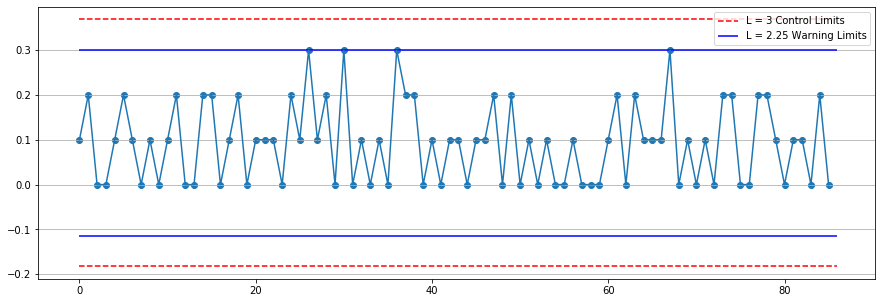

In [78]:
plt.figure(figsize = (15,5))
sampled1 = pd.DataFrame(np.array(phase1).reshape(10,86)).mean()
plt.plot(sampled1)
plt.scatter(sampled1.index,sampled1)
plt.hlines(y = [ucl,lcl], xmin = 0, xmax = 86, color = 'r', linestyle = '--', label = "L = "+str(L)+' Control Limits')
plt.hlines(y = [Wucl,Wlcl], xmin = 0, xmax = 86, color = 'b', linestyle = '-', label = "L = "+str(WL)+' Warning Limits')
plt.legend()
plt.grid(axis = 'y')

## Phase 2

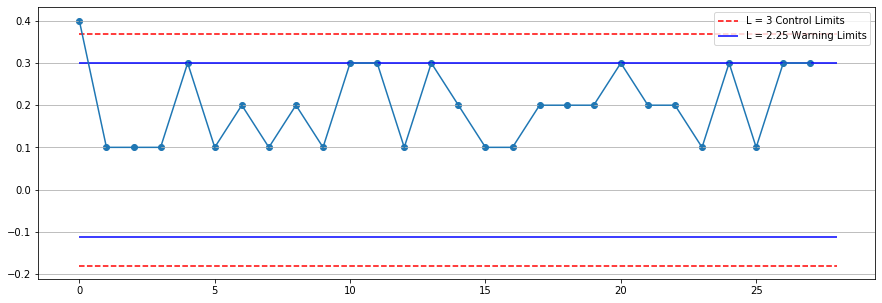

In [79]:
plt.figure(figsize = (15,5))
sampled2 = pd.DataFrame(np.array(phase2).reshape(10,28)).mean()
plt.plot(sampled2)
plt.scatter(sampled2.index,sampled2)
plt.hlines(y = [ucl,lcl], xmin = 0, xmax = 28, color = 'r', linestyle = '--', label = "L = "+str(L)+' Control Limits')
plt.hlines(y = [Wucl,Wlcl], xmin = 0, xmax = 28, color = 'b', linestyle = '-', label = "L = "+str(WL)+' Warning Limits')
plt.legend()
plt.grid(axis = 'y')